# Bivariate analysis


The objective of this notebook is to analyze each variable vs. the target to understand patterns, associations, and potential causal relationships between the variables.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import category_encoders as ce
import os
from IPython.display import Image

base_directory = 'images/images_bivar_analysis'

os.makedirs(base_directory, exist_ok=True)

In [2]:
data = pd.read_parquet('../data/silver/df_fraud_univar.parquet', engine= 'fastparquet')
data.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,no_fraud,1,1.000-10.000
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,no_fraud,1,1.000-10.000
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,fraud,1,0-1.000
3,1,CASH_OUT,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,fraud,1,0-1.000
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,no_fraud,1,10.000-100.000


## step & day_of_month vs. isFraud

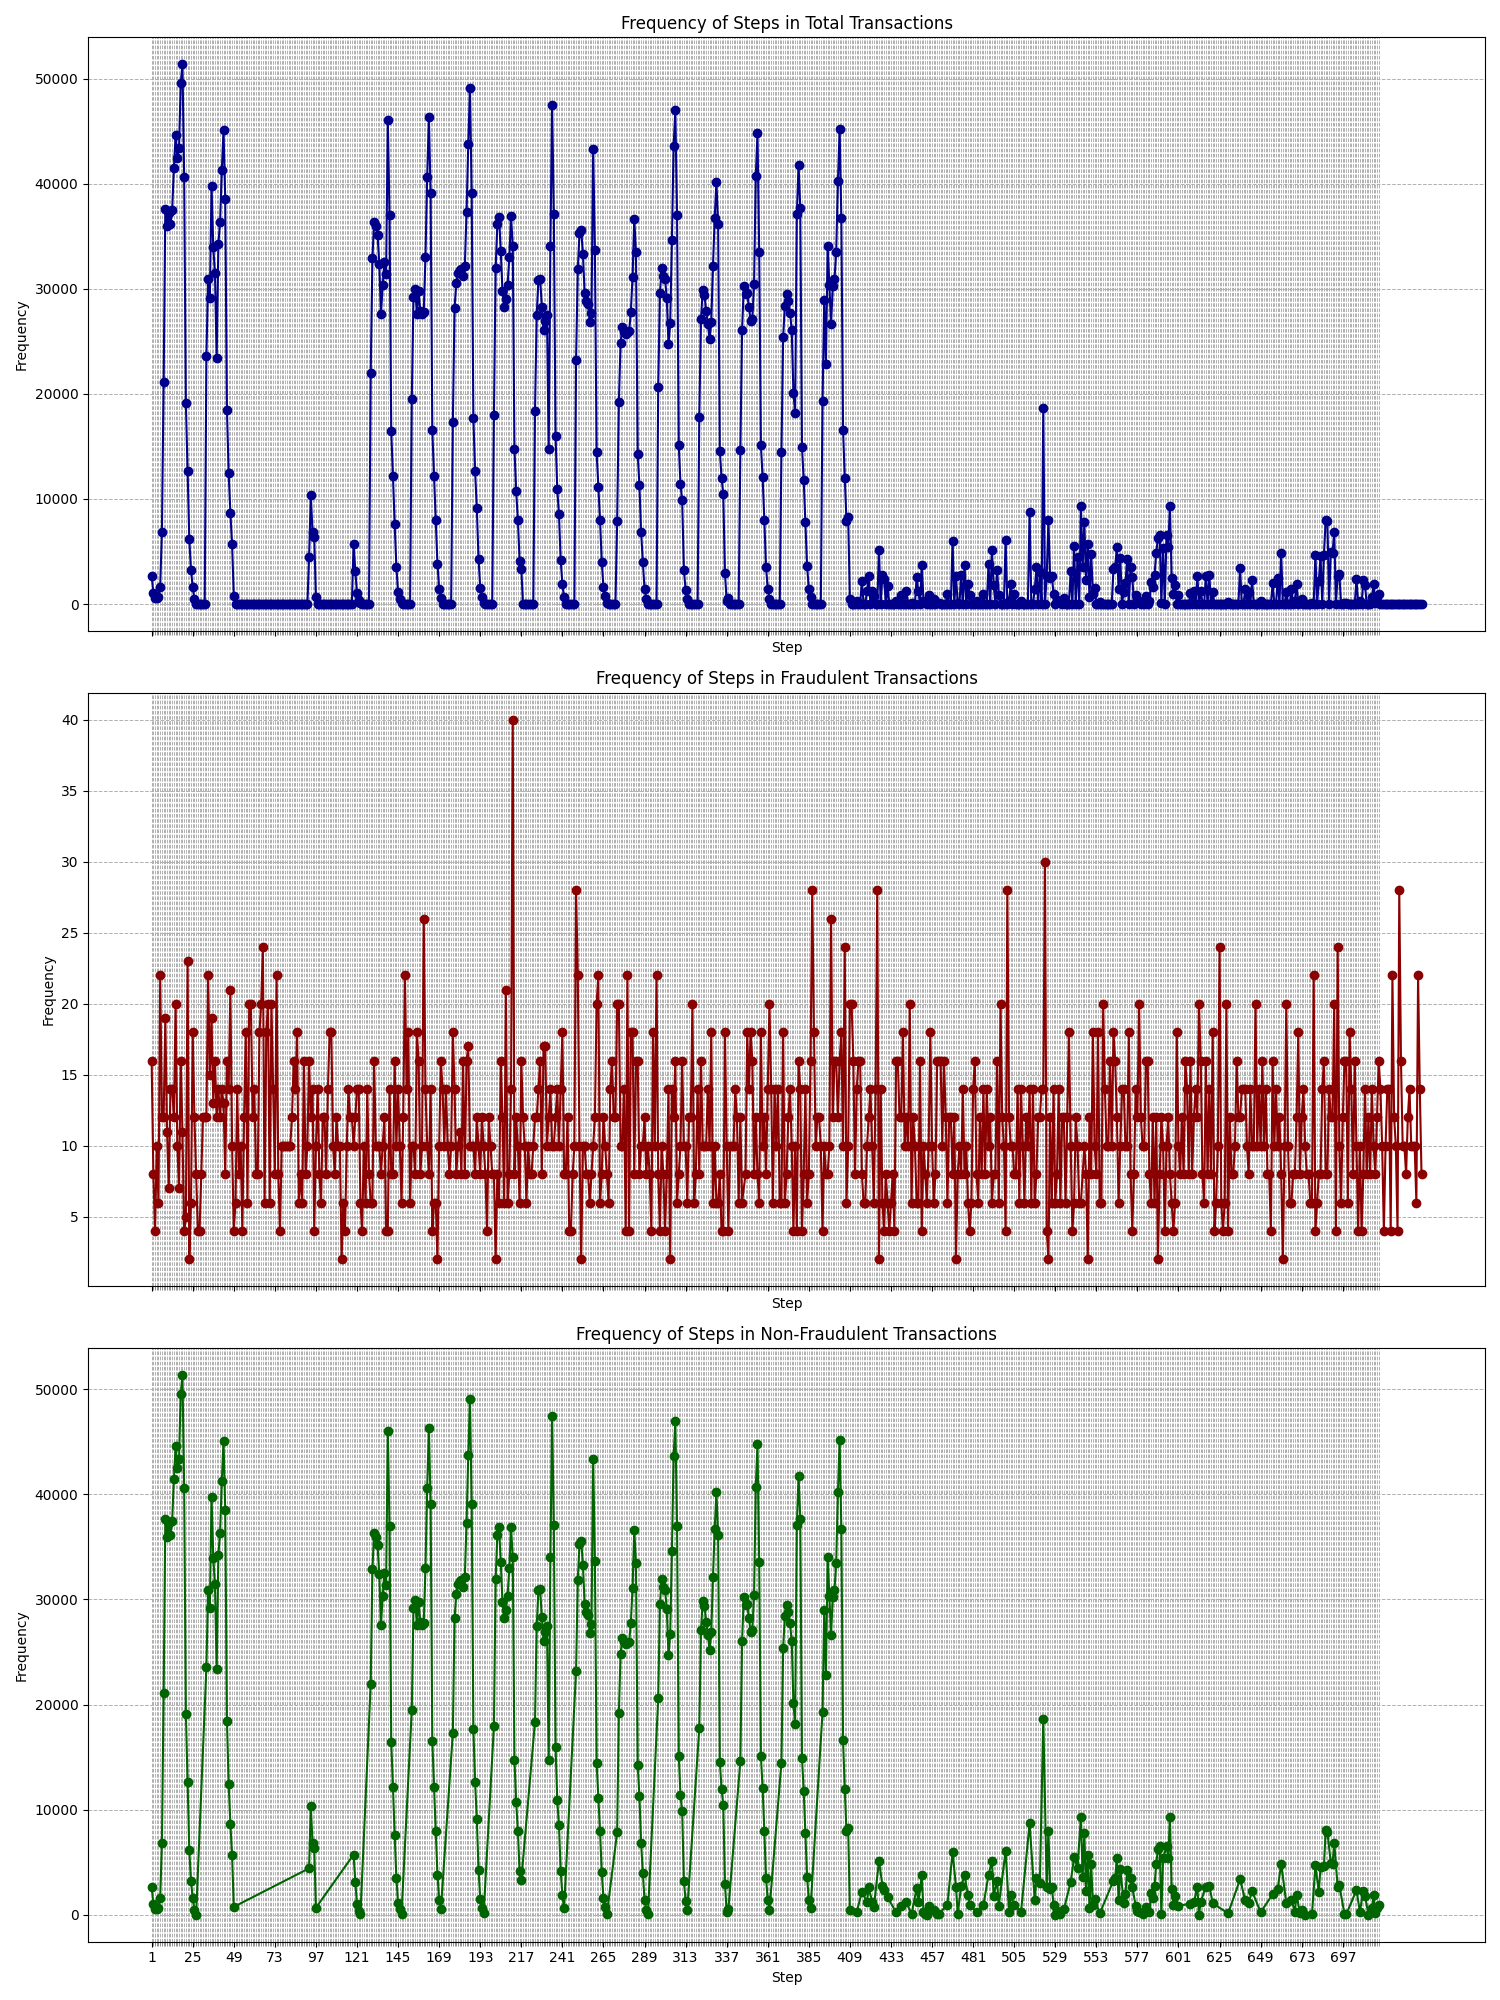

In [3]:
filename = 'freq_of_step_in_total_transactions.png'
plot_filename = os.path.join(base_directory, filename)

if not os.path.isfile(plot_filename):

    total_value_counts = data['step'].value_counts().sort_index()
    fraud_value_counts = data[data['isFraud'] == 'fraud']['step'].value_counts().sort_index()
    non_fraud_value_counts = data[data['isFraud'] == 'no_fraud']['step'].value_counts().sort_index()

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 20), sharex=True)

    titles = [
        "Frequency of Steps in Total Transactions", 
        "Frequency of Steps in Fraudulent Transactions", 
        "Frequency of Steps in Non-Fraudulent Transactions"
    ]
    colors = ['#00008B', '#8B0000', '#006400']
    counts_list = [total_value_counts, fraud_value_counts, non_fraud_value_counts]

    for ax, counts, title, color in zip(axes, counts_list, titles, colors):
        ax.plot(counts.index, counts, marker='o', color=color, linestyle='-', markersize=6)
        ax.set_title(title)
        ax.set_xlabel("Step")
        ax.set_ylabel("Frequency")
        ax.grid(True, which='both', linestyle='--', linewidth=0.7)
        ax.set_xticks(np.arange(min(counts.index), max(counts.index) + 1, 24)) 
        ax.set_xticks(np.arange(min(counts.index), max(counts.index) + 1, 1), minor=True)  
        ax.tick_params(axis='x', which='minor', length=3, color='grey')

    plt.tight_layout()
    plt.savefig(plot_filename)  
    plt.close(fig)  

Image(filename=plot_filename)

In [4]:
#TODO - fix x axis and x labels (de 24 en 24)

Observations:

For context, 1 step represents 1 hour. The total range of hour data is equivalent to a month. 

Non-fraudulent transactions vary over time, fraudulent transactions remain constant.


Non-fraudulent transactions happen inside defined step ranges and slow down when the step is a bit higher than 400 (15 days aprox). 
- The first step range makes sense since people get their salaries at the beginning of the month. 
- The second step range, as I said in the univariate analysis notebook doesn't make sense to me. In this case it would be helpful to know, for example, which month of the year it is to understand if there is any special event in the middle of the month that made people use more transactions.
- There is a gap between the first 48 and 120 hours. It would be interesting to get more information about the month, year, country from where the transaction was sent/received. Was it a bank holiday so people would be on holidays? 

Fraudulent transactions stay constant along the step range. That means fraudsters behaviour stays constant all over the month. 
- There is also a step with very high frequency between the steps 193 and 217.
- Fraudsters usually take very short time to process the transaction so it would be also nice to obtain data about the amount of time spent on the merchants website, the time used by the client to confirm the transaction (short times can indicate that a bot is actually using the platform), etc.

---

What is happening in the very frequent step? How is the relationship between that step and fraud?

In [5]:
contingency_table = pd.crosstab(data['step'], data['isFraud'])
contingency_table['total'] = contingency_table['fraud'] + contingency_table['no_fraud']
contingency_table['fraud_proportion'] = (contingency_table['fraud'] / contingency_table['total']) * 100

contingency_table.loc[(contingency_table.index > 193) & (contingency_table.index < 220)]

isFraud,fraud,no_fraud,total,fraud_proportion
step,,,,
194,12,659,671,1.788376
195,10,131,141,7.092199
196,8,0,8,100.000000
197,4,0,4,100.000000
198,12,0,12,100.000000
199,10,0,10,100.000000
200,8,0,8,100.000000
201,8,17955,17963,0.044536
202,2,31947,31949,0.006260


Observations:

There are far more fraudulent transactions on the step 212. 212 steps = 8 days + 20h.
- Why so many people are commiting fraud that day? Why at that time? Was it a coincidence? 
- Was it Black Friday or maybe another special day where a website makes offers?
Time to ask what could have happened here from a business perspective and check the characteristics of those transactions.


The are also other picks on the fraudulent transactions that could be analysed along the gaps of days between them even though the amount of fraud transactions are very constant over time. 


----

Are night transactions more likely to be fraudulent? 
- transform step into day and hour
- select the rows from 11pm to 7am
- do the same with rows from 7am to 11 pm
- density plot of both fraudulent and non fraudulent

In [6]:
data['hour_of_day'] = data['step'] % 24


In [7]:
data

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range,hour_of_day
0,1,PAYMENT,9.839640e+03,C1231006815,170136.000,160296.359375,M1979787155,0.000000e+00,0.000,no_fraud,1,1.000-10.000,1
1,1,PAYMENT,1.864280e+03,C1666544295,21249.000,19384.720703,M2044282225,0.000000e+00,0.000,no_fraud,1,1.000-10.000,1
2,1,TRANSFER,1.810000e+02,C1305486145,181.000,0.000000,C553264065,0.000000e+00,0.000,fraud,1,0-1.000,1
3,1,CASH_OUT,1.810000e+02,C840083671,181.000,0.000000,C38997010,2.118200e+04,0.000,fraud,1,0-1.000,1
4,1,PAYMENT,1.166814e+04,C2048537720,41554.000,29885.859375,M1230701703,0.000000e+00,0.000,no_fraud,1,10.000-100.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,3.396821e+05,C786484425,339682.125,0.000000,C776919290,0.000000e+00,339682.125,fraud,31,100.000-1.000.000,23
6362616,743,TRANSFER,6.311410e+06,C1529008245,6311409.500,0.000000,C1881841831,0.000000e+00,0.000,fraud,31,1.000.000-10.000.000,23
6362617,743,CASH_OUT,6.311410e+06,C1162922333,6311409.500,0.000000,C1365125890,6.848884e+04,6379898.000,fraud,31,1.000.000-10.000.000,23
6362618,743,TRANSFER,8.500025e+05,C1685995037,850002.500,0.000000,C2080388513,0.000000e+00,0.000,fraud,31,100.000-1.000.000,23


In [8]:
count_frauds_hour = data.groupby(['day_of_month','hour_of_day']).agg(
    count_fraud=pd.NamedAgg(column='isFraud', aggfunc=lambda x: (x == 'fraud').sum()),
    count_no_fraud=pd.NamedAgg(column='isFraud', aggfunc=lambda x: (x == 'no_fraud').sum())
).reset_index()

count_frauds_hour    

,day_of_month,hour_of_day,count_fraud,count_no_fraud
0,1,0,6,3210
1,1,1,16,2692
2,1,2,8,1006
3,1,3,4,548
4,1,4,10,555
...,...,...,...,...
738,31,19,10,0
739,31,20,6,0
740,31,21,22,0
741,31,22,14,0


In [9]:
nights = count_frauds_hour[(count_frauds_hour['hour_of_day'] >= 23) | (count_frauds_hour['hour_of_day'] < 7)]

grouped_night_hours = nights.groupby(['day_of_month', 'hour_of_day']).agg(
    avg_fraud=pd.NamedAgg(column='count_fraud', aggfunc='mean'),
    avg_no_fraud=pd.NamedAgg(column='count_no_fraud', aggfunc='mean')
).reset_index()

grouped_night_hours
                                                                         


,day_of_month,hour_of_day,avg_fraud,avg_no_fraud
0,1,0,6.0,3210.0
1,1,1,16.0,2692.0
2,1,2,8.0,1006.0
3,1,3,4.0,548.0
4,1,4,10.0,555.0
...,...,...,...,...
242,31,3,14.0,0.0
243,31,4,14.0,0.0
244,31,5,4.0,0.0
245,31,6,22.0,0.0


In [ ]:
days = count_frauds_hour[(count_frauds_hour['hour_of_day'] < 23) | (count_frauds_hour['hour_of_day'] >= 7)]

grouped_day_hours = days.groupby(['hour_of_day']).agg(
    avg_fraud=pd.NamedAgg(column='count_fraud', aggfunc='mean'),
    avg_no_fraud=pd.NamedAgg(column='count_no_fraud', aggfunc='mean')
).reset_index()

grouped_day_hours
                        

,day_of_month,hour_of_day,avg_fraud,avg_no_fraud
0,1,0,6.0,3210.0
1,1,1,16.0,2692.0
2,1,2,8.0,1006.0
3,1,3,4.0,548.0
4,1,4,10.0,555.0
...,...,...,...,...
738,31,19,10.0,0.0
739,31,20,6.0,0.0
740,31,21,22.0,0.0
741,31,22,14.0,0.0


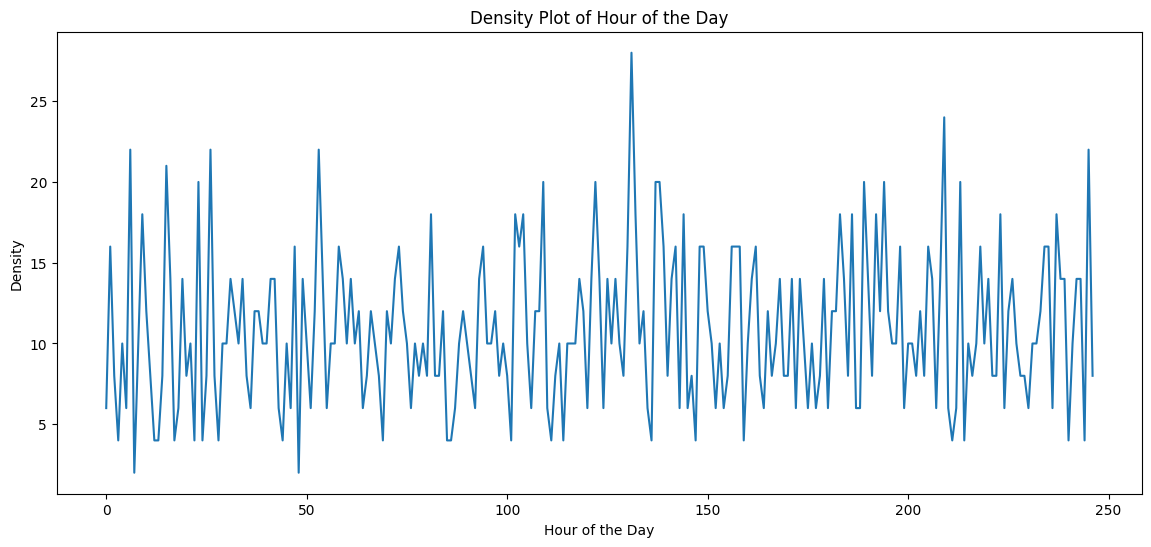

In [11]:
plt.figure(figsize=(14, 6)) 
sns.lineplot(data=grouped_night_hours['avg_fraud'])
plt.xlabel('Hour of the Day')
plt.ylabel('Density')
plt.title('Density Plot of Hour of the Day')
plt.show()

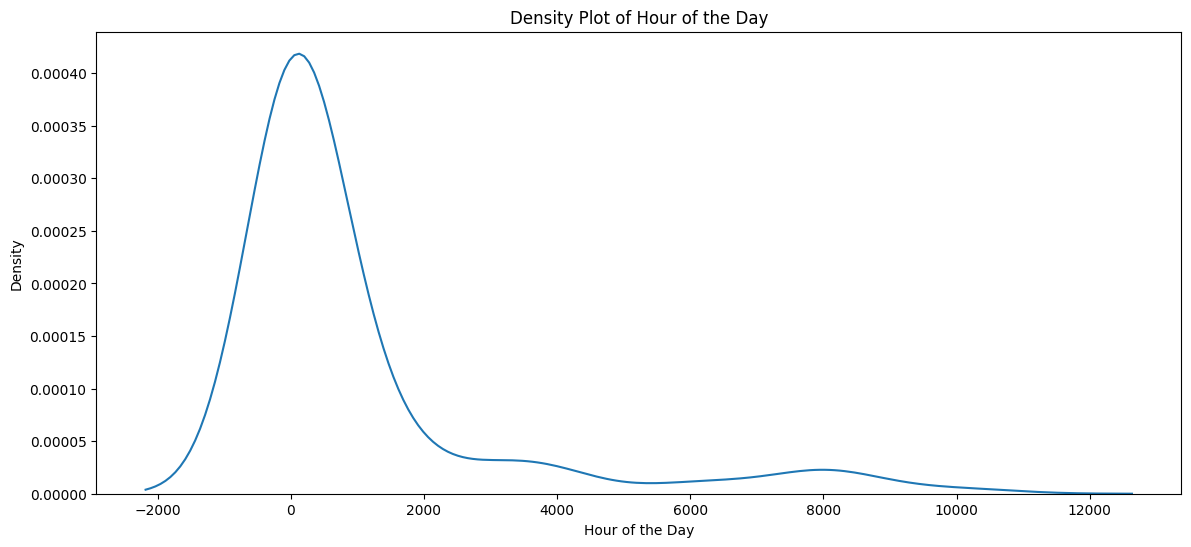

In [12]:
plt.figure(figsize=(14, 6)) 
sns.kdeplot(data=grouped_night_hours['avg_no_fraud'])
plt.xlabel('Hour of the Day')
plt.ylabel('Density')
plt.title('Density Plot of Hour of the Day')
plt.show()

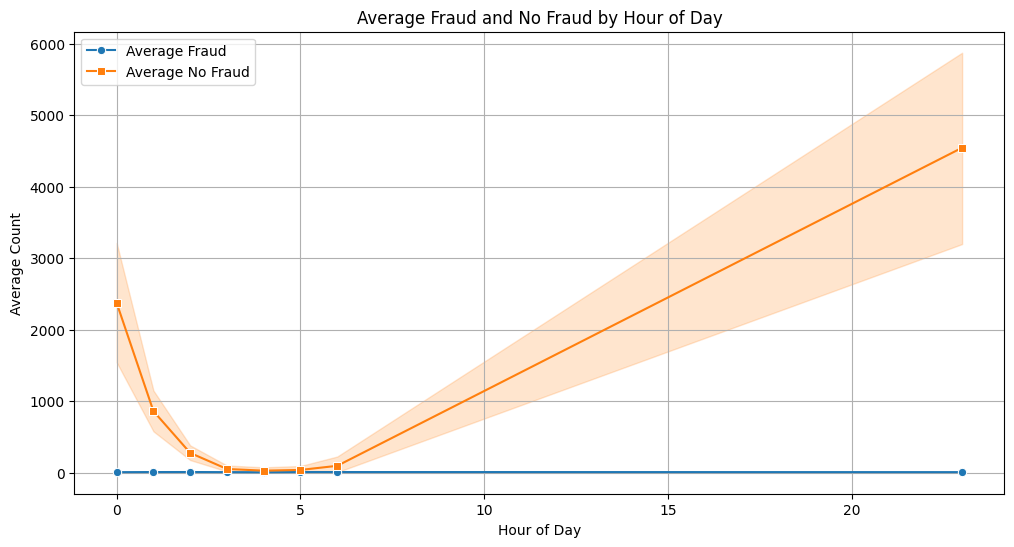

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_night_hours, x='hour_of_day', y='avg_fraud', label='Average Fraud', marker='o')
sns.lineplot(data=grouped_night_hours, x='hour_of_day', y='avg_no_fraud', label='Average No Fraud', marker='s')
plt.title('Average Fraud and No Fraud by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Count')
plt.legend()
plt.grid(True)
plt.show()

Let's check the distribution of the column "day_of_the_month"

In [14]:
contingency_table = pd.crosstab(data['day_of_month'], data['isFraud'])
contingency_table['total'] = contingency_table['fraud'] + contingency_table['no_fraud']
contingency_table['fraud_proportion'] = (contingency_table['fraud'] / contingency_table['total']) * 100
contingency_table

isFraud,fraud,no_fraud,total,fraud_proportion
day_of_month,,,,
1,271,573984,574255,0.047192
2,309,454929,455238,0.067877
3,310,760,1070,28.971963
4,262,27978,28240,0.927762
5,252,9537,9789,2.574318
6,228,440777,441005,0.051700
7,272,420311,420583,0.064672
8,278,449359,449637,0.061828
9,255,417664,417919,0.061017


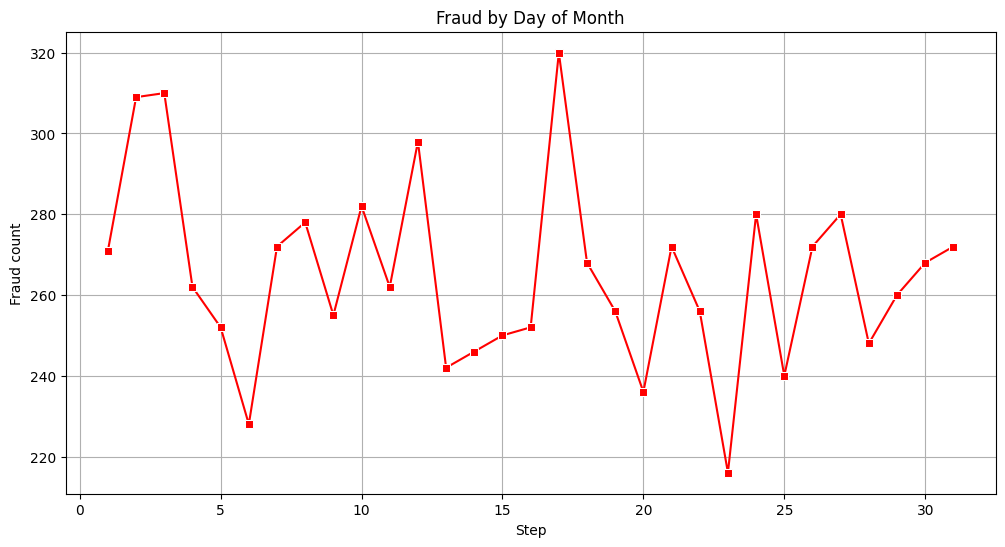

In [15]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=contingency_table, x='day_of_month', y='fraud', color = 'red', marker='s')
plt.title('Fraud by Day of Month')
plt.xlabel('Step')
plt.ylabel('Fraud count')
plt.grid(True)
plt.show()

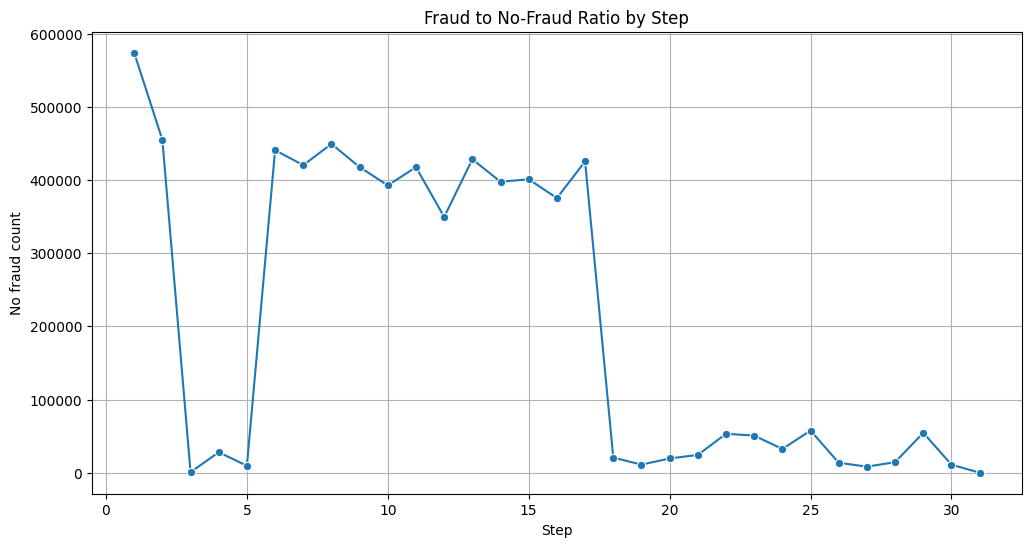

In [16]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=contingency_table, x='day_of_month', y='no_fraud', marker='o')
plt.title('Fraud to No-Fraud Ratio by Step')
plt.xlabel('Step')
plt.ylabel('No fraud count')
plt.grid(True)
plt.show()

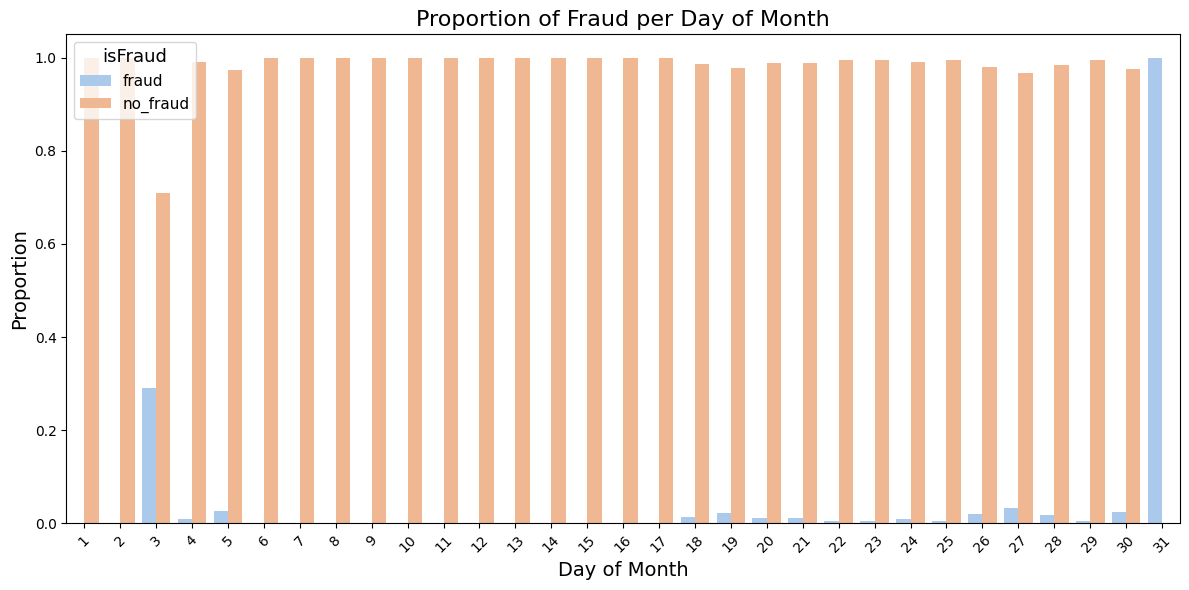

In [17]:
df_grouped = data.groupby(['day_of_month', 'isFraud'], observed=False).size().reset_index(name='count')
df_grouped['proportion'] = df_grouped.groupby('day_of_month')['count'].transform(lambda x: x / x.sum())

palette = sns.color_palette("pastel", n_colors=2)

# Crear el gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_month', y='proportion', hue='isFraud', data=df_grouped, palette=palette)

plt.title('Proportion of Fraud per Day of Month', fontsize=16)
plt.xlabel('Day of Month', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=45)  # Rotar etiquetas en el eje x para mejor legibilidad
plt.legend(title='isFraud', title_fontsize='13', fontsize='11')
plt.tight_layout()  # Ajustar diseño para que no se corten elementos
plt.show()

Observations:

- The last day of the month has only fraudulent transactions. Curious, right? I would need more info about the context but it looks like it's a coincidence.
- In the same days where non fraudulent transactions (remember we had the hypothesis that it would may be )
Besides that I don't see any clear pattern.

## type vs. isFraud

In [18]:
data.dtypes

step                 int16
type              category
amount             float32
nameOrig          category
oldbalanceOrig     float32
newbalanceOrig     float32
nameDest          category
oldbalanceDest     float32
newbalanceDest     float32
isFraud           category
day_of_month          int8
amount_range      category
hour_of_day          int16
dtype: object

In [19]:
contingency_table = pd.crosstab(data['type'], data['isFraud'])
contingency_table

isFraud,fraud,no_fraud
type,,
CASH_IN,0,1399284
CASH_OUT,4116,2233384
DEBIT,0,41432
PAYMENT,0,2151495
TRANSFER,4097,528812


Observations:

The only types that have fraudulent transactions are CASH_OUT and TRANSFER and as we saw in the univariate analysis they are substantially less common

-------

## amount vs. isFraud

In [20]:
data.query('amount == 0')

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range,hour_of_day
2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.000000e+00,0.000000e+00,fraud,9,0-1.000,20
3247298,250,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.000000e+00,0.000000e+00,fraud,11,0-1.000,10
3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,5.385476e+05,5.385476e+05,fraud,12,0-1.000,15
5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7.970766e+06,7.970766e+06,fraud,17,0-1.000,3
5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,7.675990e+04,7.675990e+04,fraud,18,0-1.000,17
5996410,425,CASH_OUT,0.0,C69493310,0.0,0.0,C719711728,2.921531e+06,2.921531e+06,fraud,18,0-1.000,17
6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,2.302897e+05,2.302897e+05,fraud,24,0-1.000,2
6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1.328473e+06,1.328473e+06,fraud,25,0-1.000,10
6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.000000e+00,0.000000e+00,fraud,26,0-1.000,17
6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.000000e+00,0.000000e+00,fraud,27,0-1.000,22


Observations:

Withrawals with amount = 0 are fraudulent, none of them is repeated and they have been used to try to withdraw money. We could analyze the origin and destination users and see their behaviour. One example could be using the postal code, the IP data, the account age, etc. to find hidden patterns.


----
Is the type of small amount transactions (less than 40k) found in the univariate analysis related to fraudulent behaviour? 


In [21]:
small_amounts = data.query('amount < 40000')
small_amounts

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range,hour_of_day
0,1,PAYMENT,9839.639648,C1231006815,170136.000000,160296.359375,M1979787155,0.000000,0.000000,no_fraud,1,1.000-10.000,1
1,1,PAYMENT,1864.280029,C1666544295,21249.000000,19384.720703,M2044282225,0.000000,0.000000,no_fraud,1,1.000-10.000,1
2,1,TRANSFER,181.000000,C1305486145,181.000000,0.000000,C553264065,0.000000,0.000000,fraud,1,0-1.000,1
3,1,CASH_OUT,181.000000,C840083671,181.000000,0.000000,C38997010,21182.000000,0.000000,fraud,1,0-1.000,1
4,1,PAYMENT,11668.139648,C2048537720,41554.000000,29885.859375,M1230701703,0.000000,0.000000,no_fraud,1,10.000-100.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362512,734,TRANSFER,23912.199219,C1790385148,23912.199219,0.000000,C1671472479,0.000000,0.000000,fraud,31,10.000-100.000,14
6362513,734,CASH_OUT,23912.199219,C4748745,23912.199219,0.000000,C1953200125,338951.656250,362863.843750,fraud,31,10.000-100.000,14
6362566,739,TRANSFER,8116.529785,C2072430566,8116.529785,0.000000,C765215468,0.000000,0.000000,fraud,31,1.000-10.000,19
6362567,739,CASH_OUT,8116.529785,C564539602,8116.529785,0.000000,C1935865739,7638.259766,15754.790039,fraud,31,1.000-10.000,19


In [22]:
%store small_amounts

Stored 'small_amounts' (DataFrame)


In [23]:
small_amounts['isFraud'].value_counts()

isFraud
no_fraud    2621706
fraud           858
Name: count, dtype: int64

In [24]:
small_amounts['isFraud'].value_counts(normalize=True).mul(100).apply(lambda x: f'{x:.3f}%')

isFraud
no_fraud    99.967%
fraud        0.033%
Name: proportion, dtype: object

Observations:

It seems that there's no visible apprearance of fraud transactions in small amounts

In [25]:
more_4k_amounts = data.query('400000 < amount')

In [26]:
%store more_4k_amounts

Stored 'more_4k_amounts' (DataFrame)


In [27]:
more_4k_amounts['isFraud'].value_counts()

isFraud
no_fraud    525122
fraud         4273
Name: count, dtype: int64

In [28]:
more_4k_amounts['isFraud'].value_counts(normalize=True).mul(100).apply(lambda x: f'{x:.3f}%')

isFraud
no_fraud    99.193%
fraud        0.807%
Name: proportion, dtype: object

Observations:

No visible relationship, let's dive deeper into bigger accounts

In [29]:
is_cached = False
try:
    %store -r repeated_amounts
    is_cached = True
except NameError:
    is_cached = False

if is_cached:
    print("The DataFrame is already stored in cache")
else:
    print("DataFrame not found. Calculating...")

    repeated_rows = data[data.duplicated('amount', keep=False) & (data['amount'] != 0)]

    repeated_amounts = (repeated_rows.groupby('amount')
                    .agg(count_is_not_Fraud=('isFraud', lambda x: (x == 'no_fraud').sum()),
                            count_isFraud=('isFraud', lambda x: (x == 'fraud').sum()),
                            percentage_is_not_Fraud=('isFraud', lambda x: round((x == 'no_fraud').mean() * 100, 2)),
                            percentage_isFraud=('isFraud', lambda x: round((x == 'fraud').mean() * 100, 2)))
                    .reset_index())

    %store repeated_amounts

repeated_amounts

The DataFrame is already stored in cache


,amount,count_is_not_Fraud,count_isFraud,percentage_is_not_Fraud,percentage_isFraud
0,0.02,3,0,100.00,0.00
1,0.03,2,0,100.00,0.00
2,0.11,2,0,100.00,0.00
3,0.14,2,0,100.00,0.00
4,0.18,2,0,100.00,0.00
...,...,...,...,...,...
851675,9960382.00,0,2,0.00,100.00
851676,9977761.00,0,2,0.00,100.00
851677,9996887.00,0,2,0.00,100.00
851678,10000000.00,2920,287,91.05,8.95


In [30]:
repeated_amounts[(repeated_amounts['amount'] > 60) & (repeated_amounts['amount'] < 80)]

,amount,count_is_not_Fraud,count_isFraud,percentage_is_not_Fraud,percentage_isFraud
2395,60.020000,4,0,100.0,0.0
2396,60.029999,4,0,100.0,0.0
2397,60.049999,2,0,100.0,0.0
2398,60.080002,2,0,100.0,0.0
2399,60.139999,2,0,100.0,0.0
...,...,...,...,...,...
3209,79.889999,2,0,100.0,0.0
3210,79.910004,2,0,100.0,0.0
3211,79.970001,2,0,100.0,0.0
3212,79.980003,2,0,100.0,0.0


In [31]:
data.query('amount == 38.439999')

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range,hour_of_day
527518,20,PAYMENT,38.439999,C1742594262,1.173970e+03,1.135530e+03,M1504067698,0.000,0.0000,no_fraud,1,0-1.000,20
1646544,157,CASH_IN,38.439999,C106088958,1.128239e+07,1.128243e+07,C2117215775,776372.875,776334.4375,no_fraud,7,0-1.000,13
4778162,335,PAYMENT,38.439999,C1907490030,3.090740e+05,3.090356e+05,M1842921904,0.000,0.0000,no_fraud,14,0-1.000,23


In [32]:
plt.figure(figsize=(12, 6))
sns.swarmplot(x='isFraud', y='amount', data=data)
plt.title('Violin Plot of Amount by Fraud Status')
plt.xlabel('Fraud Status')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [ ]:
is_cached = False

try:
    %store -r correlation
    if 'integer_amounts' in locals():
        is_cached = True
except (NameError, KeyError):
    is_cached = False

if is_cached:
    print("The integer amounts var is stored in cache")
else:
    print("integer_amounts not found. Calculating...")
    integer_rows = data[data['amount'] == data['amount'].astype(int)]

    integer_amounts = integer_rows.groupby('amount').apply(lambda x: pd.Series({
        'count': x.shape[0],
        'percentage_isFraud_0': (x['isFraud'] == 0).mean() * 100,
        'percentage_isFraud_1': (x['isFraud'] == 1).mean() * 100
    })).reset_index()
    
    %store integer_amounts
    
integer_amounts

integer_amounts not found. Calculating...
Stored 'integer_amounts' (DataFrame)


/tmp/ipykernel_155003/3892314397.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  integer_amounts = integer_rows.groupby('amount').apply(lambda x: pd.Series({


,amount,count,percentage_isFraud_0,percentage_isFraud_1
0,0.0,16.0,0.0,0.0
1,1.0,1.0,0.0,0.0
2,2.0,1.0,0.0,0.0
3,3.0,2.0,0.0,0.0
4,5.0,1.0,0.0,0.0
...,...,...,...,...
103475,69337320.0,1.0,0.0,0.0
103476,69886728.0,1.0,0.0,0.0
103477,71172480.0,1.0,0.0,0.0
103478,73823488.0,1.0,0.0,0.0


## nameOrig vs. isFraud

From the univariate analysis we found that there were many transactions with the same amount. Let's check them

## oldbalanceOrig vs. isFraud

## newbalanceOrig vs. isFraud

---

### Correlation

In [ ]:
numerical_cols = data.select_dtypes(include=['float32', 'int16']).columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
numerical_cols


Index(['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')

In [ ]:
is_cached = False

try:
    %store -r correlation
    if 'correlation' in locals():
        is_cached = True
except (NameError, KeyError):
    is_cached = False

if is_cached:
    print("The correlation matrix is stored in cache")
else:
    print("Correlation matrix not found. Calculating...")
    
    encoder = ce.TargetEncoder(cols=categorical_cols)
    
    target_col = numerical_cols[0]
    
    df_encoded = encoder.fit_transform(data, data[target_col])
    correlation = df_encoded.corr()

    %store correlation


The correlation matrix is stored in cache


In [ ]:
correlation

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
step,1.000000,0.013760,0.022373,0.999264,-0.010058,-0.010299,0.603271,0.027665,0.025888,0.031578,0.999586,0.033385
type,0.013760,1.000000,0.117539,0.013746,0.152440,0.159545,0.047891,-0.027514,-0.015565,0.006886,0.013283,0.101450
amount,0.022373,0.117539,1.000000,0.022360,-0.002762,-0.007861,-0.063719,0.294137,0.459304,0.076688,0.023473,0.495951
nameOrig,0.999264,0.013746,0.022360,1.000000,-0.010063,-0.010305,0.602818,0.027639,0.025864,0.031563,0.998849,0.033366
oldbalanceOrig,-0.010058,0.152440,-0.002762,-0.010063,1.000000,0.998803,-0.075316,0.066243,0.042029,0.010154,-0.009940,-0.000797
newbalanceOrig,-0.010299,0.159545,-0.007861,-0.010305,0.998803,1.000000,-0.076943,0.067812,0.041837,-0.008148,-0.010181,-0.009221
nameDest,0.603271,0.047891,-0.063719,0.602818,-0.075316,-0.076943,1.000000,-0.257550,-0.250388,0.021638,0.601662,-0.004134
oldbalanceDest,0.027665,-0.027514,0.294137,0.027639,0.066243,0.067812,-0.257550,1.000000,0.976569,-0.005885,0.027878,0.120624
newbalanceDest,0.025888,-0.015565,0.459304,0.025864,0.042029,0.041837,-0.250388,0.976569,1.000000,0.000535,0.026274,0.219529
isFraud,0.031578,0.006886,0.076688,0.031563,0.010154,-0.008148,0.021638,-0.005885,0.000535,1.000000,0.032425,0.054086


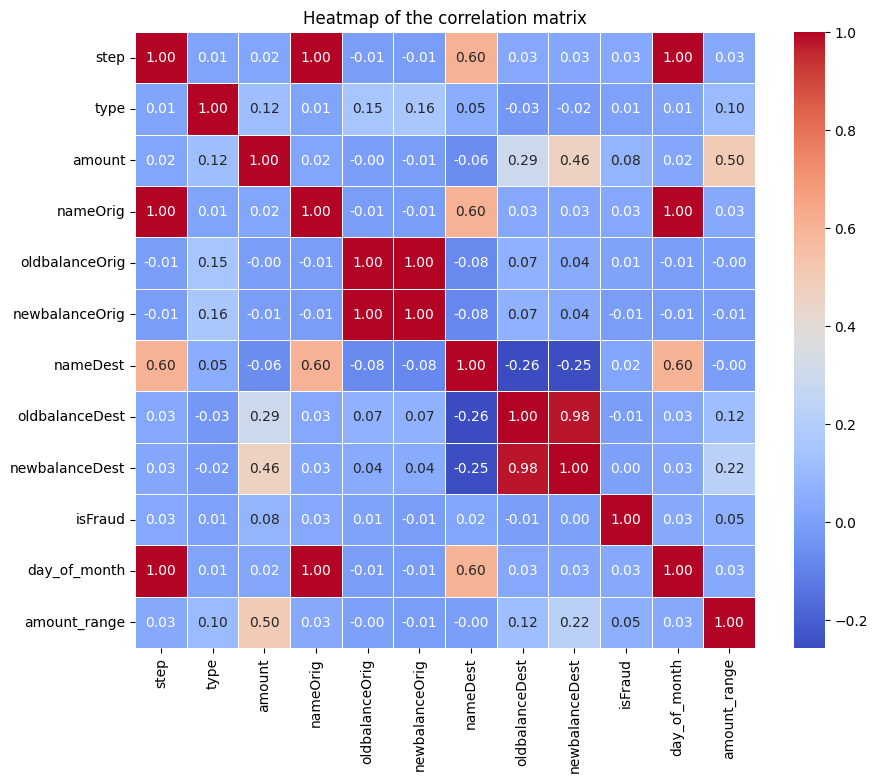

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of the correlation matrix')
plt.show()

In [ ]:

threshold = 0.9

high_correlation_pairs = [(col1, col2) for col1 in correlation.columns for col2 in correlation.columns 
                          if col1 != col2 and abs(correlation.loc[col1, col2]) > threshold]

variables_to_remove = set()
for col1, col2 in high_correlation_pairs:
    if col1 not in variables_to_remove and col2 not in variables_to_remove:
        variables_to_remove.add(col2)

print(f"Variables to remove due to high correlation: {variables_to_remove}")

reduced_df = df_encoded.drop(columns=variables_to_remove)

reduced_correlation = reduced_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(reduced_correlation, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of the Reduced Correlation Matrix')
plt.show()

Variables to remove due to high correlation: {'nameOrig', 'newbalanceOrig', 'day_of_month', 'newbalanceDest'}


NameError: name 'df_encoded' is not defined

In [ ]:
reduced_df.to_parquet('../data/gold/df_final.parquet', engine= 'fastparquet')